# Training chemCPA

## Download data

This notebook has two dependencies:

sciplex3
wget 
rdkit embeddings

This notebook is a self-contained way to train the chemCPA model.

In [16]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import wandb
from hydra import compose, initialize
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from omegaconf import OmegaConf
from plotnine import aes, geom_boxplot, ggplot, scale_y_continuous
from pytorch_lightning.loggers import WandbLogger
import os
from ipywidgets import Text, VBox

from chemCPA.data import DataModule
from chemCPA.model import ComPert
from chemCPA.train import evaluate_logfold_r2, evaluate_r2, evaluate_r2_sc

wandb.login()

True

In [17]:
### Load config

with initialize(version_base=None, config_path="../experiments/hydra_config"):
    config = compose(config_name="defaults", overrides=[])


In [18]:
print(OmegaConf.to_yaml(config.dataset.data_params))
assert (Path(config.dataset.data_params.dataset_path)).exists(), "Config `dataset_path` is not correct!"
assert (Path(config.dataset.data_params.drugs_embeddings)).exists(), "Config `drugs_embeddings` is not correct"

dataset_path: /root/chemCPA_fork/sciplex_complete_middle_subset_lincs_genes.h5ad
drug_key: condition
dose_key: dose
knockout_key: null
covariate_keys:
- cell_type
smiles_key: SMILES
pert_category: cov_drug_dose_name
split_key: split_ood_multi_task
degs_key: lincs_DEGs
drugs_embeddings: /root/chemCPA_fork/rdkit2D_embedding_lincs_trapnell.parquet
knockouts_embeddings: null
return_dataset: true



In [89]:
### Load data module

dm = DataModule(
    batch_size=config.model["hparams"]["batch_size"],
    full_eval_during_train=config.train["full_eval_during_train"],
    num_workers=config.train["num_workers"],
    # num_workers=19,
    **config.dataset["data_params"]
)

print(dm.datasets['training'].num_covariates)
print(dm.datasets['training'].num_drugs)
print(dm.datasets['training'].num_knockouts)


# Load the model

#### Determine checkpoint path

We assume the results are stored where the config.model.save_dir points to, but you can change it, if that's not the case



In [90]:
# Load model from checkpoint
CHECKPOINT_DIR = Path(config.model.save_dir + "/CPA_Sciplex_Lincs")

# Create a text input field for CHECKPOINT_DIR with default value as the computed path
checkpoint_dir_input = Text(value=str(CHECKPOINT_DIR), description='Checkpoint Directory:')
display(VBox([checkpoint_dir_input]))

# Update CHECKPOINT_DIR based on user input
CHECKPOINT_DIR = Path(checkpoint_dir_input.value)

# Get the last modified folder name
all_subdirs = [CHECKPOINT_DIR / d for d in os.listdir(CHECKPOINT_DIR) if os.path.isdir(CHECKPOINT_DIR / d)]

and by default we read the latest model

In [91]:
if all_subdirs:  # Check if there are any subdirectories
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    run_id = latest_subdir.name
else:
    raise Exception("No subdirectories found in CHECKPOINT_DIR")

# Create a text input field for run_id with default value as the computed id
run_id_input = Text(value=run_id, description='Run ID:')
display(VBox([run_id_input]))

print(CHECKPOINT_DIR)

_checkpoints = CHECKPOINT_DIR / f"{run_id}" / "checkpoints"
assert _checkpoints.exists(), "Checkpoints directory does not exist"
checkpoint = list(_checkpoints.iterdir())[-1]

/root/chemCPA_fork/model_outputs/CPA_Sciplex_Lincs


### Load model

In [92]:
print(f"Loading checkpoint: {checkpoint}")
model = ComPert.load_from_checkpoint(checkpoint)
# /root/chemCPA_fork/model_outputs/CPA_Sciplex_Lincs/26tvsxyv/checkpoints/epoch=89-step=220320.ckpt

Loading checkpoint: /root/chemCPA_fork/model_outputs/CPA_Sciplex_Lincs/26tvsxyv/checkpoints/epoch=164-step=403920.ckpt


## Perform evaluation


In [81]:
# #draw the logfold r2
# def draw_logfold_r2(autoencoder, ds_treated, ds_ctrl):
#     logfold_score, signs_score = evaluate_logfold_r2(autoencoder, ds_treated, ds_ctrl, return_mean=False)
#     df = pd.DataFrame(
#         data = {'logfold_score': logfold_score, 'signs_score': signs_score}
#     )
#     df = pd.melt(df, value_vars=['logfold_score', 'signs_score'], var_name='score_type', value_name='score')
#     p = ggplot(df, aes(x='factor(score_type)', y='score', fill='factor(score_type)')) + geom_boxplot() + scale_y_continuous(limits=(-1,1))
#     return p

In [82]:
import numpy as np
import torch
from tqdm.auto import tqdm

from chemCPA.train import (
    bool2idx,
    compute_prediction,
    compute_r2,
    filter_out_bad_conditions,
    set_up_covariates,
)


def compute_pred(
    model,
    dataset,
    dosages=[1e4],
    cell_lines=None,
    genes_control=None,
    use_DEGs=True,
    verbose=True,
):
    # dataset.pert_categories contains: 'celltype_perturbation_dose' info
    pert_categories_index = pd.Index(dataset.pert_categories, dtype="category")

    # allowed_cell_lines = []

    # cl_dict = {
    #     torch.Tensor([1, 0, 0]): "A549",
    #     torch.Tensor([0, 1, 0]): "K562",
    #     torch.Tensor([0, 0, 1]): "MCF7",
    # }

    # if cell_lines is None:
    #     cell_lines = ["A549", "K562", "MCF7"]

    print(cell_lines)

    predictions_dict = {}
    drug_r2 = {}
    n_obs = genes_control.size(0)
    iterator = zip(*np.unique(dataset.pert_categories, return_counts=True))
    for cell_pert_comb, category_count in tqdm(iterator):
        # print(cell_pert_comb)
        if (dataset.drug_key is None) and (dataset.knockout_key is None):
            break
        if filter_out_bad_conditions(category_count, cell_pert_comb)=='continue':
            continue

        # dataset.var_names is the list of gene names
        # dataset.de_genes is a dict, containing a list of all differentiably-expressed
        # genes for every cell_drug_dose combination.
        bool_de = dataset.var_names.isin(
            np.array(dataset.de_genes[cell_pert_comb])
        )
        idx_de = bool2idx(bool_de)

        # need at least two genes to be able to calc r2 score
        if len(idx_de) < 2:
            continue

        bool_category = pert_categories_index.get_loc(cell_pert_comb)
        idx_all = bool2idx(bool_category)
        idx = idx_all[0]

        covs, drugs, knockouts = set_up_covariates(dataset, idx, n_obs)
        covs = torch.concat(covs)
        drugs = [torch.concat(d) for d in drugs]
        
        model.eval()
        mean_pred, var_pred = compute_prediction(
            model,
            genes_control.to(model.device),
            drugs,
            knockouts,
            covs
        )
        y_true = dataset.genes[idx_all, :].to(device=model.device)
        y_pred = mean_pred
        # _y_pred = mean_pred.mean(0)
        # _y_true = y_true.mean(0)
        # if use_DEGs:
        #     r2_m_de = compute_r2(_y_true[idx_de].cuda(), _y_pred[idx_de].cuda())
        #     print(f"{cell_drug_dose_comb}: {r2_m_de:.2f}") if verbose else None
        #     drug_r2[cell_drug_dose_comb] = max(r2_m_de, 0.0)
        # else:
        #     r2_m = compute_r2(_y_true.cuda(), _y_pred.cuda())
        #     print(f"{cell_drug_dose_comb}: {r2_m:.2f}") if verbose else None
        #     drug_r2[cell_drug_dose_comb] = max(r2_m, 0.0)

        # predictions_dict[cell_drug_dose_comb] = [_y_true, _y_pred, idx_de]
        predictions_dict[cell_pert_comb] = [genes_control.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), y_true.detach().cpu().numpy()]
    return drug_r2, predictions_dict

In [93]:
drug_r2, predictions_dict = compute_pred(model=model, dataset=dm.datasets['training'], genes_control=dm.datasets['test_control'].genes, use_DEGs=False, verbose=True)

None


0it [00:00, ?it/s]

In [25]:
# import pickle 

# # load file with pickle 
# old_results = "/nfs/homedirs/hetzell/code/chemCPA/notebooks/drug_r2_pretrained_all.pkl"
# with open(old_results, "rb") as f:
#     predicitons_pretrained = pickle.load(f)

In [15]:
# predicitons_pretrained

In [69]:
# ood_drugs = np.unique(dm.datasets["ood"].drugs_names)
drugs = np.unique(dm.datasets['training'].drugs_names)[:9]

In [70]:
predictions = []
targets = []
cl_p = []
cl_t = []
d_p = []
d_t = []
for key, vals in predictions_dict.items(): 
    cl, drug, _ = key.split("_")
    if ('1.0' in key) and (drug in drugs):
        print(key)
        control = vals[0]
        predictions.append(vals[1])
        targets.append(vals[2])
        cl_p.extend(vals[1].shape[0] * [cl])
        cl_t.extend(vals[2].shape[0] * [cl])
        d_p.extend(vals[1].shape[0] * [drug])
        d_t.extend(vals[2].shape[0] * [drug])

A549_2-Methoxyestradiol_1.0
A549_A-366_1.0
A549_ABT-737_1.0
A549_AC480_1.0
A549_AG-14361_1.0
A549_AG-490_1.0
A549_AICAR_1.0
A549_AMG-900_1.0
A549_AR-42_1.0
K562_2-Methoxyestradiol_1.0
K562_A-366_1.0
K562_ABT-737_1.0
K562_AC480_1.0
K562_AG-14361_1.0
K562_AG-490_1.0
K562_AICAR_1.0
K562_AMG-900_1.0
K562_AR-42_1.0
MCF7_2-Methoxyestradiol_1.0
MCF7_A-366_1.0
MCF7_ABT-737_1.0
MCF7_AC480_1.0
MCF7_AG-14361_1.0
MCF7_AG-490_1.0
MCF7_AICAR_1.0
MCF7_AMG-900_1.0
MCF7_AR-42_1.0


In [84]:
import anndata as ad

adata_c = ad.AnnData(control)
adata_p = ad.AnnData(np.concatenate(predictions, axis=0))
adata_t = ad.AnnData(np.concatenate(targets, axis=0))

adata_c.obs['condition'] = 'control'
adata_c.obs['cell_line'] = 'control'
adata_c.obs['perturbation'] = 'control'
adata_p.obs['condition'] = 'prediction'
adata_p.obs['cell_line'] = cl_p
adata_p.obs['perturbation'] = d_p
adata_t.obs['condition'] = 'target'
adata_t.obs['cell_line'] = cl_t
adata_t.obs['perturbation'] = d_t

adata = ad.concat([adata_c,adata_p,adata_t])

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [85]:
adata

AnnData object with n_obs × n_vars = 36721 × 977
    obs: 'condition', 'cell_line', 'perturbation'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

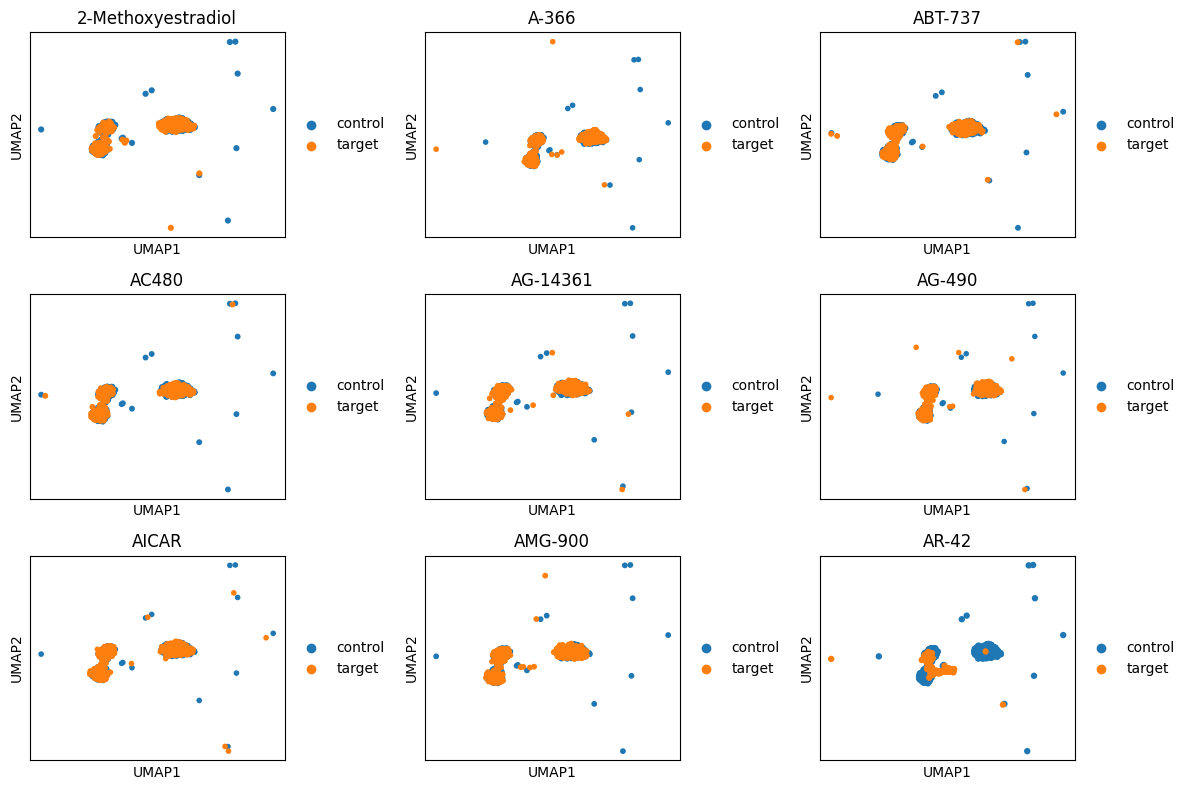

In [86]:
_drugs = drugs

fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i, pert in enumerate(_drugs):
    axis = ax[i//3, i%3]
    cond = (adata.obs["condition"] == "control") + ((adata.obs["condition"] == "target") * (adata.obs["perturbation"] == pert))
    sc.pl.umap(adata[cond].copy(), color="condition", ax=axis, show=False)
    axis.set_title(f"{pert}")
plt.tight_layout()

In [87]:
# R2
def draw_r2(autoencoder, dataset, genes_control):
    mean_score, mean_score_de, var_score, var_score_de = evaluate_r2(autoencoder, dataset, genes_control, return_mean=False)
    df = pd.DataFrame(
        data = {'mean_score': mean_score, 
                'mean_score_de': mean_score_de,
                'var_score': var_score,
                'var_score_de':var_score_de
                }
    )
    df = pd.melt(df, value_vars=['mean_score', 'mean_score_de', 'var_score', 'var_score_de'], 
                 var_name='score_type', value_name='score')
    p = ggplot(df, aes(x='factor(score_type)', y='score', fill='factor(score_type)')) + geom_boxplot()+ scale_y_continuous(limits=(0,1))
    return p

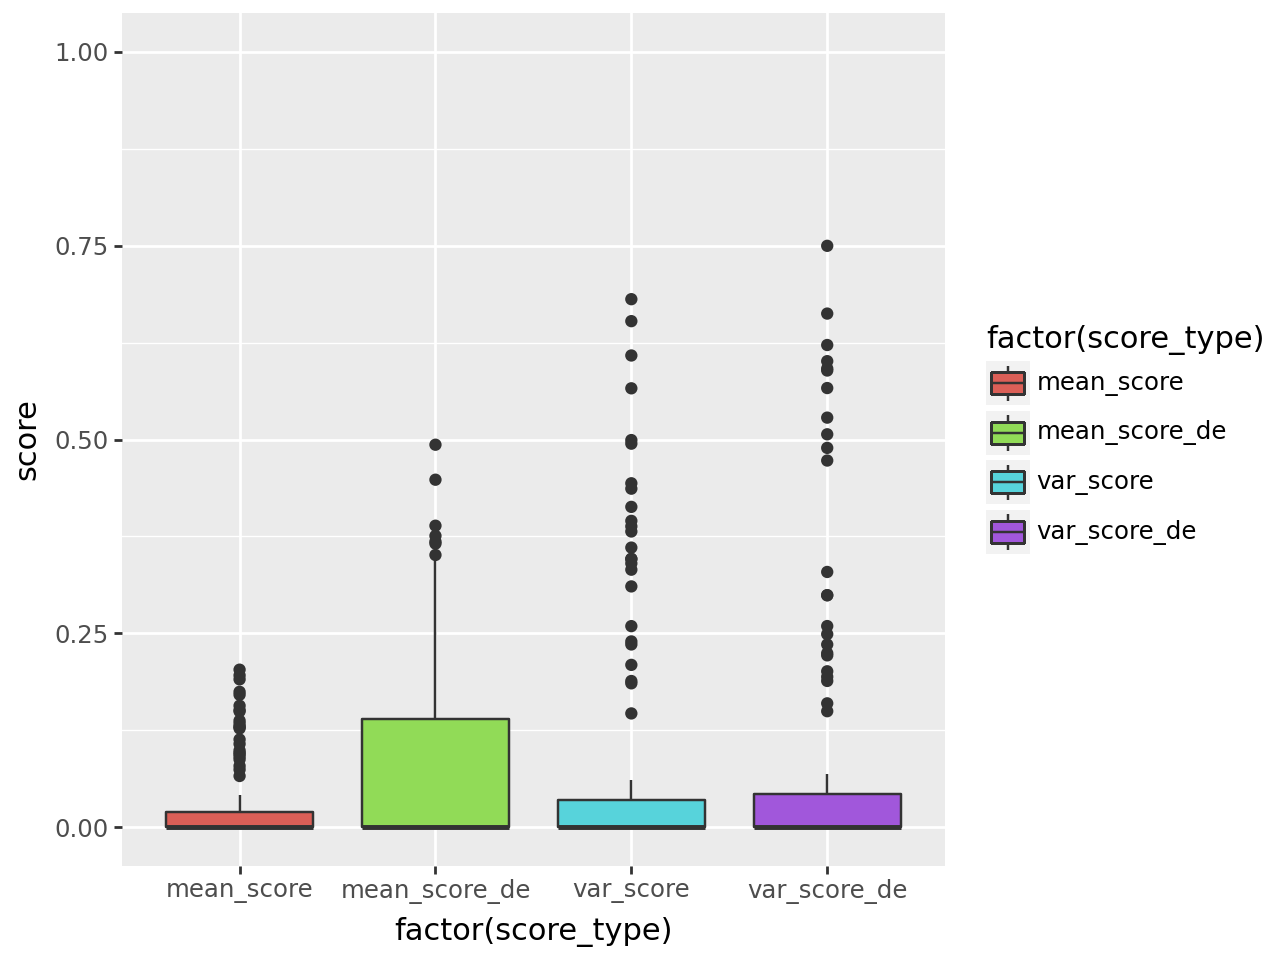

In [75]:
draw_r2(model, dm.datasets['ood'], dm.datasets["test_control"].genes)

In [ ]:
# #draw the r2 sc
# def draw_r2_sc(autoencoder, dataset):
#     mean_score, mean_score_de, var_score, var_score_de = evaluate_r2_sc(autoencoder, dataset, return_mean=False)
#     df = pd.DataFrame(
#         data = {'mean_score': mean_score, 
#                 'mean_score_de': mean_score_de,
#                 'var_score': var_score,
#                 'var_score_de':var_score_de
#                 }
#     )
#     df = pd.melt(df, value_vars=['mean_score', 'mean_score_de', 'var_score', 'var_score_de'], 
#                  var_name='score_type', value_name='score')
#     p = ggplot(df, aes(x='factor(score_type)', y='score', fill='factor(score_type)')) + geom_boxplot()+ scale_y_continuous(limits=(0,1))
#     return p